In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv("Real estate.csv")

In [2]:
y = data.iloc[:,-1]
data.drop(['Y house price of unit area', 'No'], axis=1, inplace=True)

In [3]:
data.head()

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude
0,2012.917,32.0,84.87882,10,24.98298,121.54024
1,2012.917,19.5,306.59470,9,24.98034,121.53951
2,2013.583,13.3,561.98450,5,24.98746,121.54391
3,2013.500,13.3,561.98450,5,24.98746,121.54391
4,2012.833,5.0,390.56840,5,24.97937,121.54245


In [4]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('______')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(data,y,test_size=0.2, random_state=2)

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(data=scaler.transform(X_train),columns = X_train.columns,index=X_train.index)
X_test = pd.DataFrame(data=scaler.transform(X_test),columns = X_test.columns,index=X_test.index)

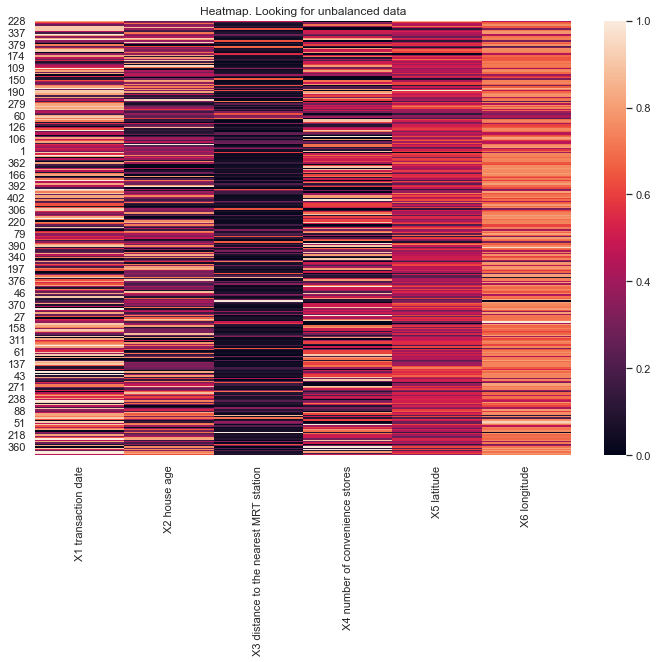

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.figure(figsize=(12, 8))
ax = sns.heatmap(X_train)
ax.set_title('Heatmap. Looking for unbalanced data')
plt.show()

<h1> Outliers <h1>

In [8]:
# Create a tool to find outliers
from scipy.special import erfc
# compliments to you , using this

def chauvenet(array):
    mean = array.mean() # mean
    stdv = array.std()#std
    criterion = 1.0/(2*(len(array)))  # read this link https://www.statisticshowto.com/chauvenets-criterion/
    d = abs(array - mean)/stdv  # Distance of a value to mean in stdv's
    prob = erfc(d)  #NORM DIST
    return prob < criterion

In [9]:
num_outliers = pd.Series(dtype='float64')
for feature in data:
    num_outliers[feature] = chauvenet(data[feature]).sum()
print(num_outliers)

X1 transaction date                        0
X2 house age                               1
X3 distance to the nearest MRT station    33
X4 number of convenience stores            0
X5 latitude                                9
X6 longitude                              15
dtype: int64


In [471]:
# Deleting outliers
X_train_new = X_train.copy()
y_train_new = pd.DataFrame(y_train)
for feature in X_train_new:
    X_train_new[feature + ' outliers'] = chauvenet(X_train_new[feature])
    y_train_new[feature + ' outliers'] = chauvenet(X_train_new[feature])
features_outliers = ['X1 transaction date outliers', 'X2 house age outliers', 
            'X3 distance to the nearest MRT station outliers',
            'X4 number of convenience stores outliers',
            'X5 latitude outliers',
            'X6 longitude outliers']
for feature in features_outliers:
    X_train_new = X_train_new[X_train_new[feature] == False]
    y_train_new = y_train_new[y_train_new[feature] == False]

X_train_new.drop(columns=features_outliers, inplace=True)
y_train_new.drop(columns=features_outliers, inplace=True)
y_train_new = pd.Series(y_train_new['Y house price of unit area'])


In [10]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(data,y,test_size=0.2, random_state=None)

In [494]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(data=scaler.transform(X_train),columns = X_train.columns,index=X_train.index)
X_test = pd.DataFrame(data=scaler.transform(X_test),columns = X_test.columns,index=X_test.index)

In [498]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=100, random_state=2)
rf_reg.fit(X_train_new, y_train_new)

test_pred = rf_reg.predict(X_test)
train_pred = rf_reg.predict(X_train_new)

print('Testing set evaluation:\n______')
print_evaluate(y_test, test_pred)
print('==*******==')
print('Training set evaluation:\n_____')
print_evaluate(y_train_new, train_pred)

Testing set evaluation:
______
MAE: 3.015710355708546
MSE: 23.188641765846448
RMSE: 4.815458624663537
R2 Square 0.878199103339318
______
==*******==
Training set evaluation:
_____
MAE: 1.8896029152915272
MSE: 10.828444157459211
RMSE: 3.2906601400720814
R2 Square 0.9357734511779401
______


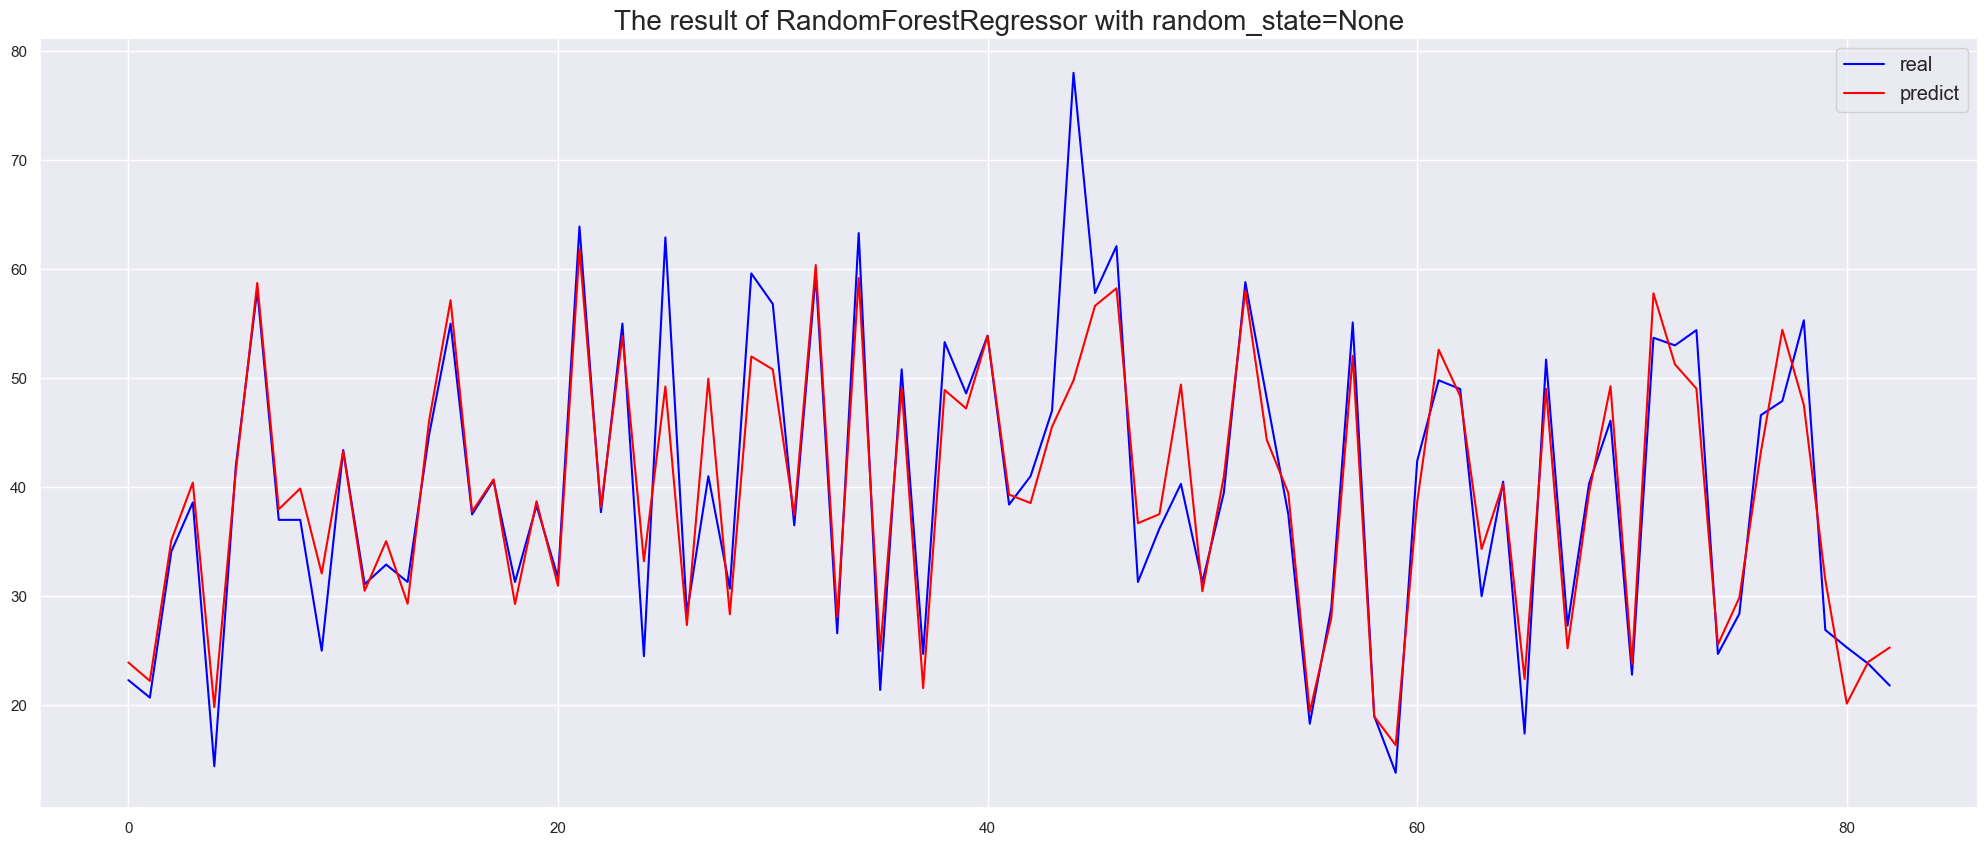

In [497]:
plt.figure(figsize=(25,10))
plt.plot(y_test.to_numpy(dtype=object)[:200],c='blue')
plt.plot(test_pred[:200],c='red')
plt.annotate(
# Label and coordinate
'outlier!', xy=(50, 115), xytext=(20, 120),

# Custom arrow
arrowprops=dict(facecolor='black', shrink=0.1)
)
plt.legend(['real','predict'],fontsize="large")
plt.title('The result of RandomForestRegressor with random_state=None', fontsize=20)
plt.show()